In [1]:
#!pip install --upgrade mplfinance
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 
import os

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("preprocessed_CAC40.csv", parse_dates=['Date'])
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [3]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97648 entries, 0 to 97647
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     97648 non-null  int64         
 1   Name           97648 non-null  object        
 2   Date           97648 non-null  datetime64[ns]
 3   Open           97418 non-null  float64       
 4   Closing_Price  97646 non-null  float64       
 5   Daily_High     97444 non-null  float64       
 6   Daily_Low      97444 non-null  float64       
 7   Volume         77195 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 6.0+ MB


In [21]:
#df.drop(['Unnamed: 0'], axis=1, inplace=True)
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

company_name = np.random.choice(df['Name'].unique().tolist())
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2024,1,1)

specific_df = specific_data(company_name, start_date, end_date)
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
20794,Cap Gemini,2020-04-02,73.54,73.54,73.54,73.54,2
20795,Cap Gemini,2020-04-01,74.34,74.02,74.98,74.02,20
20796,Cap Gemini,2020-03-31,77.94,79.24,79.44,77.94,230
20797,Cap Gemini,2020-03-30,78.80,77.60,78.80,77.60,105
20798,Cap Gemini,2020-03-27,80.00,77.40,80.00,77.40,174


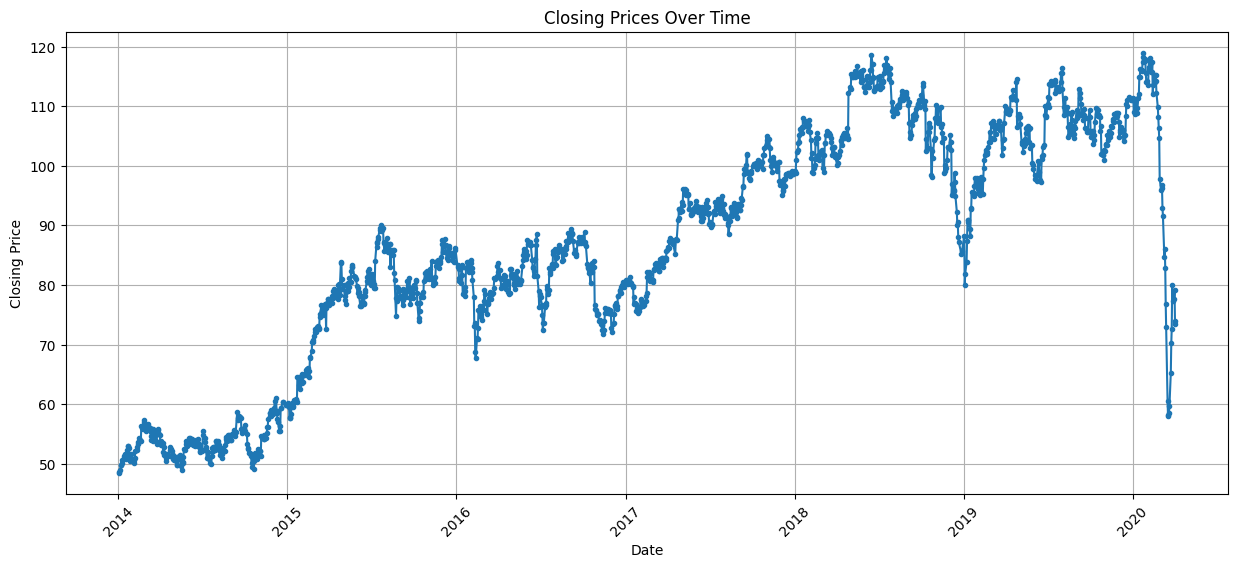

In [22]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

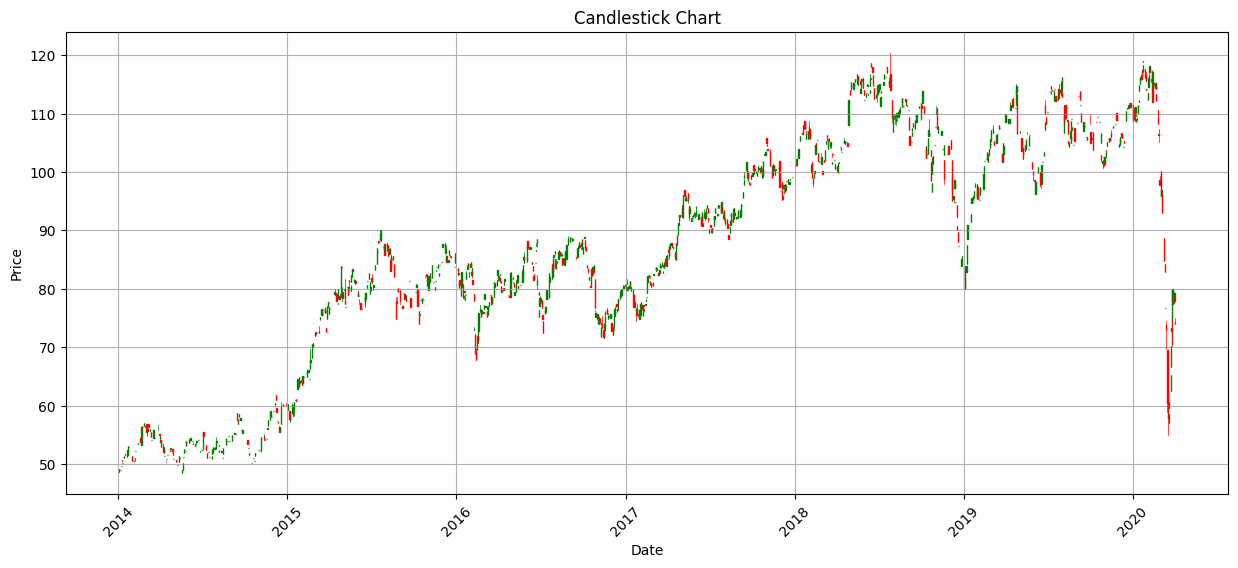

In [23]:
matplotlib_date = mdates.date2num(specific_df['Date'])
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

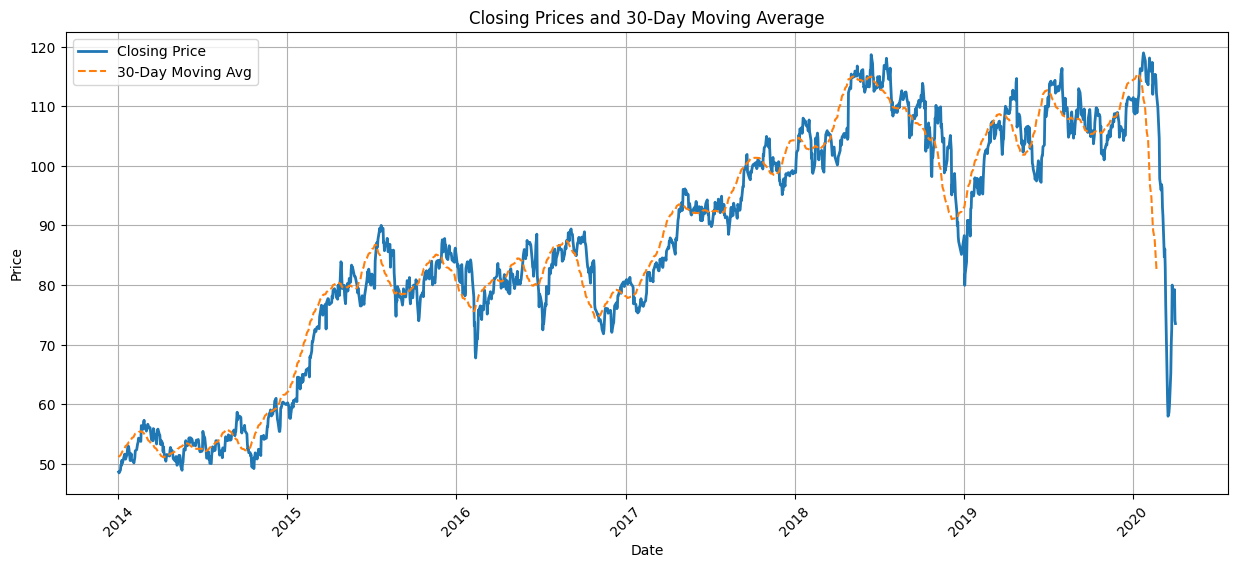

In [24]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

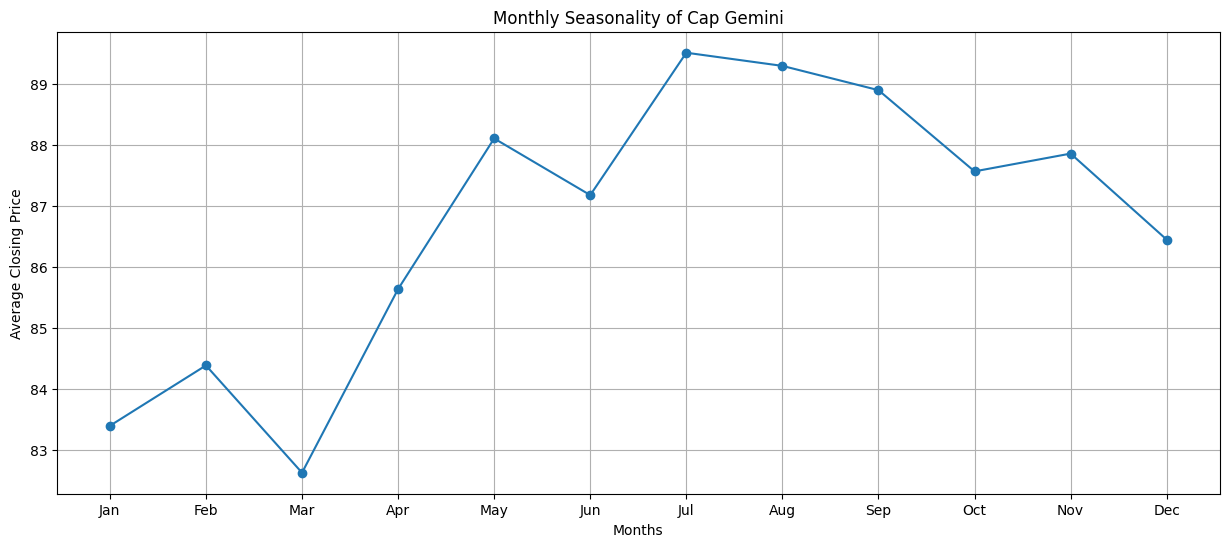

In [25]:
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [26]:
new_df = specific_df.reset_index()['Closing_Price']
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [27]:
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1204, 60)
(1204,)


Testing set size:-
(256, 60)
(256,)


(None, None)

In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [29]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss='mean_squared_error',optimizer='adam')
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5.keras', save_best_only = True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.1099 - val_loss: 0.0232
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0124 - val_loss: 0.0074
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0074 - val_loss: 0.0020
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0074 - val_loss: 0.0013
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0064 - val_loss: 0.0011
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0081 - val_loss: 0.0023
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0060 - val_loss: 0.0020
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step

In [31]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [32]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

93.61495357064115
53.73705132428733


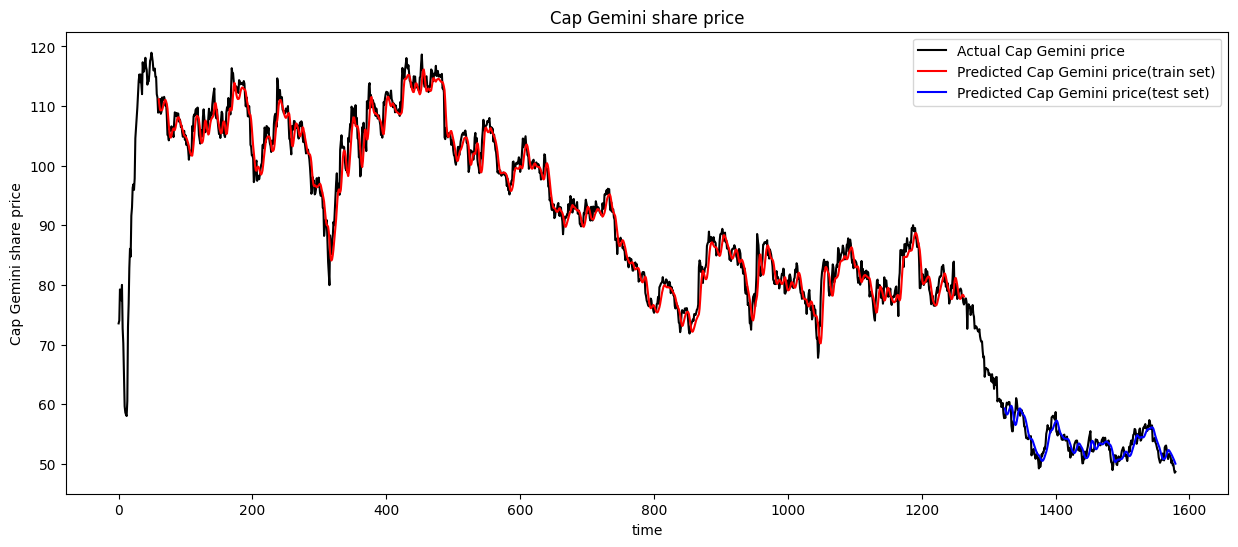

In [33]:
look_back = 60
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()
original_scaled_data = scaler.inverse_transform(scaled_data)
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()

In [34]:
last_sequence = X_test[-1]

last_sequence = last_sequence.reshape(1, n_past, 1)
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 50.008522033691406
Day 2: Predicted Price = 49.76081085205078
Day 3: Predicted Price = 49.61439514160156
Day 4: Predicted Price = 49.55554962158203
Day 5: Predicted Price = 49.55525588989258
Day 6: Predicted Price = 49.586639404296875
Day 7: Predicted Price = 49.63087844848633
Day 8: Predicted Price = 49.67723846435547
Day 9: Predicted Price = 49.72079086303711
Day 10: Predicted Price = 49.760040283203125


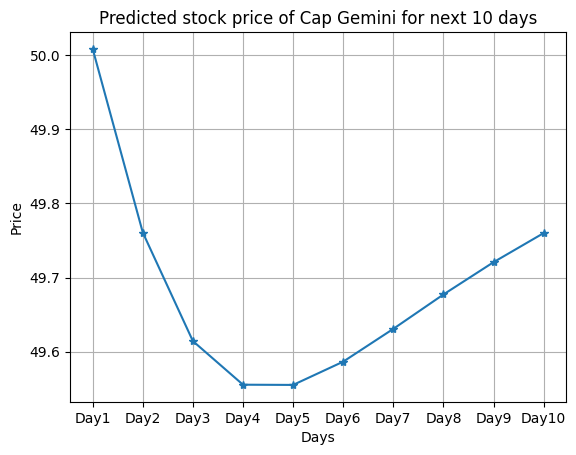

In [35]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()